<a href="https://colab.research.google.com/github/codersavage/AttentionVAESpatialTranscriptomicsInpainting/blob/main/Attention_with_beta_VAE_for_Spatial_Transcriptomics_Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !git clone https://github.com/mahmoodlab/HEST

Cloning into 'HEST'...
remote: Enumerating objects: 771, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 771 (delta 181), reused 151 (delta 139), pack-reused 508 (from 2)
Receiving objects: 100% (771/771), 37.14 MiB | 22.53 MiB/s, done.
Resolving deltas: 100% (369/369), done.


In [ ]:
# !pip install -e ./HEST

Obtaining file:///content/HEST
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.4/359.4 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. 

In [ ]:
!pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import scanpy as sc
import scipy.sparse
import os
import anndata
from typing import Dict, List, Tuple, Union, Optional

class SpatialPatchDataset(Dataset):
    """
    Dataset for spatial transcriptomics data that creates patches and
    simulates dropouts using Zero-Inflated Negative Binomial distribution.
    """

    def __init__(self,
                 adata: anndata.AnnData,
                 patch_size: int = 10,
                 dropout_prob: float = 0.3,
                 dispersion: float = 1.0,
                 include_spatial: bool = True,
                 normalize_counts: bool = True,
                 log_transform: bool = True,
                 min_spots_per_patch: int = 4,
                 seed: int = 42):
        """
        Initialize the dataset.

        Args:
            adata: AnnData object containing spatial transcriptomics data
            patch_size: Size of patches to extract
            dropout_prob: Zero-inflation parameter (dropout probability)
            dispersion: Dispersion parameter for NB distribution
            include_spatial: Include spatial coordinates in output
            normalize_counts: Normalize counts to counts per million
            log_transform: Apply log1p transformation
            min_spots_per_patch: Minimum spots required in a patch
            seed: Random seed for reproducibility
        """
        self.adata = adata
        self.patch_size = patch_size
        self.dropout_prob = dropout_prob
        self.dispersion = dispersion
        self.include_spatial = include_spatial
        self.normalize_counts = normalize_counts
        self.log_transform = log_transform
        self.min_spots_per_patch = min_spots_per_patch

        # Set random seed
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Process the data
        self._preprocess_data()

        # Extract patches
        self.patches = self._extract_patches()

        print(f"Created dataset with {len(self.patches)} patches from {adata.n_obs} spots and {adata.n_vars} genes")

    def _preprocess_data(self):
        """Preprocess data: store raw counts, then optionally normalize and log transform for model input"""

        # Store raw counts for dropout simulation
        if isinstance(self.adata.X, np.ndarray):
            self.raw_expr_matrix = self.adata.X.copy()
        elif scipy.sparse.issparse(self.adata.X):
            self.raw_expr_matrix = self.adata.X.toarray()
        else:
            raise TypeError("Unknown data type for adata.X")

        print("hi!!!")
        print(self.raw_expr_matrix)

        # Prepare processed matrix for model input (optional normalization/log)
        self.expr_matrix = self.raw_expr_matrix.copy()
        if self.normalize_counts:
            spot_sums = np.sum(self.expr_matrix, axis=1, keepdims=True)
            spot_sums[spot_sums == 0] = 1  # Avoid division by zero
            self.expr_matrix = self.expr_matrix / spot_sums * 1e6

        if self.log_transform:
            self.expr_matrix = np.log1p(self.expr_matrix)

        # Get spatial coordinates
        if 'spatial' in self.adata.obsm:
            self.spatial_coords = self.adata.obsm['spatial'].copy()
        else:
            # Look for spatial coordinates in other keys
            for key in self.adata.obsm.keys():
                if 'spatial' in key.lower() or 'coord' in key.lower():
                    self.spatial_coords = self.adata.obsm[key].copy()
                    break
            else:
                # Create dummy coordinates if none found
                print("WARNING: No spatial coordinates found. Creating a grid...")
                n_spots = self.adata.n_obs
                grid_size = int(np.ceil(np.sqrt(n_spots)))
                x = np.repeat(np.arange(grid_size), grid_size)[:n_spots]
                y = np.tile(np.arange(grid_size), grid_size)[:n_spots]
                self.spatial_coords = np.column_stack((x, y))

    def _extract_patches(self):
        """Extract patches from the spatial data"""
        patches = []
        # Get min and max coordinates
        x_min, y_min = np.min(self.spatial_coords, axis=0)
        x_max, y_max = np.max(self.spatial_coords, axis=0)

        # Calculate patch dimensions
        x_step = (x_max - x_min) / (2 * self.patch_size)  # 50% overlap.
        y_step = (y_max - y_min) / (2 * self.patch_size)
        x_window = (x_max - x_min) / self.patch_size
        y_window = (y_max - y_min) / self.patch_size

        # Slide window across the space
        for x_start in np.arange(x_min, x_max - x_window + 1e-6, x_step):
            for y_start in np.arange(y_min, y_max - y_window + 1e-6, y_step):
                x_end = x_start + x_window
                y_end = y_start + y_window

                # Find spots within the window
                in_window = ((self.spatial_coords[:, 0] >= x_start) &
                             (self.spatial_coords[:, 0] < x_end) &
                             (self.spatial_coords[:, 1] >= y_start) &
                             (self.spatial_coords[:, 1] < y_end))

                indices = np.where(in_window)[0]

                # Only keep windows with enough spots
                if len(indices) >= self.min_spots_per_patch:
                    patches.append(indices)

        return patches

    def _apply_zinb_dropout(self, expression_data):
        """
        Apply Zero-Inflated Negative Binomial dropout to gene expression data.

        Args:
            expression_data: Gene expression data of shape (n_spots, n_genes)

        Returns:
            Expression data with ZINB dropout
        """
        # Make a copy to avoid modifying the original data
        dropped_data = expression_data.copy()

        # Apply dropout for each gene
        for gene_idx in range(expression_data.shape[1]):
            gene_expr = expression_data[:, gene_idx]

            # Skip genes with no expression
            non_zero = gene_expr > 0
            if np.sum(non_zero) == 0:
                continue

            # Calculate mean expression
            mean_expr = np.mean(gene_expr[non_zero])

            # Calculate dropout probability (higher for genes with lower expression)
            gene_dropout_prob = self.dropout_prob * np.exp(-0.1 * mean_expr)
            gene_dropout_prob = min(0.95, max(0.05, gene_dropout_prob))

            # Apply dropout
            for i in range(len(gene_expr)):
                if gene_expr[i] > 0:
                    if np.random.random() < gene_dropout_prob:
                        dropped_data[i, gene_idx] = 0

        return dropped_data

    def __len__(self):
        """Return the number of patches in the dataset"""
        return len(self.patches)

    def __getitem__(self, idx):
        """
        Get a sample of original and dropped data for a patch.

        Args:
            idx: Index of the patch

        Returns:
            tuple: (dropped_tensor, original_tensor, [coords_tensor])
        """
        # Get indices for the current patch
        patch_indices = self.patches[idx]

        # Get **raw** expression data for the patch for ZINB dropout simulation
        raw_expression_data = self.raw_expr_matrix[patch_indices]
        dropped_expression_raw = self._apply_zinb_dropout(raw_expression_data)

        # Now apply normalization/log to both
        if self.normalize_counts:
            spot_sums = np.sum(raw_expression_data, axis=1, keepdims=True)
            spot_sums[spot_sums == 0] = 1
            original_expression = raw_expression_data / spot_sums * 1e6
            dropped_expression = dropped_expression_raw / spot_sums * 1e6
        else:
            original_expression = raw_expression_data.copy()
            dropped_expression = dropped_expression_raw.copy()

        if self.log_transform:
            original_expression = np.log1p(original_expression)
            dropped_expression = np.log1p(dropped_expression)

        # Get spatial coordinates for the patch
        spatial_coords = self.spatial_coords[patch_indices]

        # Normalize coordinates within the patch to [0, patch_size -1] (integer coordinates)
        x_coords = spatial_coords[:, 0]
        y_coords = spatial_coords[:, 1]

        x_min = int(np.min(x_coords))
        y_min = int(np.min(y_coords))
        x_max = int(np.max(x_coords))
        y_max = int(np.max(y_coords))

        # Calculate patch size based on the range of coordinates
        patch_size_x = x_max - x_min + 1
        patch_size_y = y_max - y_min + 1

        # Create a grid-like tensor for expression data with shape (patch_size, patch_size, n_genes)
        original_expression_grid = torch.zeros(patch_size_x, patch_size_y, self.adata.n_vars)
        dropped_expression_grid = torch.zeros(patch_size_x, patch_size_y, self.adata.n_vars)

        # Fill the grid with expression values based on spot coordinates
        for i, spot_idx in enumerate(patch_indices):
            x = int(spatial_coords[i, 0] - x_min)  # Shift coordinates to start from 0
            y = int(spatial_coords[i, 1] - y_min)

            original_expression_grid[x, y] = torch.FloatTensor(original_expression[i])
            dropped_expression_grid[x, y] = torch.FloatTensor(dropped_expression[i])

        if self.include_spatial:  # (Optional) Include spatial coordinates
            coords_tensor = torch.FloatTensor(spatial_coords)
            return dropped_expression_grid, original_expression_grid, coords_tensor
        else:
            return dropped_expression_grid, original_expression_grid


In [ ]:
import torch


train_dataset = torch.load('/content/drive/My Drive/Project!/train_dataset_correct_zinb.pt', weights_only=False)
val_dataset = torch.load('/content/drive/My Drive/Project!/val_dataset_correct_zinb.pt', weights_only=False)


In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
        """
        Custom collate function to handle variable-sized patches.
        Pads patches to the maximum size in the batch and centers them.
        """
        # Find maximum dimensions within the batch
        max_x = max(item[0].shape[0] for item in batch)
        max_y = max(item[0].shape[1] for item in batch)
        num_genes = batch[0][0].shape[2]  # Assuming all have same num_genes

        # Target patch size (e.g., 10 x 10)
        target_patch_size = 10

        # Pad patches
        dropped_batch = []
        original_batch = []
        coords_batch = []
        for dropped, original, coords in batch:
            # Calculate padding for centering
            pad_x = (target_patch_size - dropped.shape[0]) // 2
            pad_y = (target_patch_size - dropped.shape[1]) // 2

            # Pad with zeros to center
            padded_dropped = torch.zeros(target_patch_size, target_patch_size, num_genes, dtype=dropped.dtype)
            padded_dropped[pad_x : pad_x + dropped.shape[0], pad_y : pad_y + dropped.shape[1], :] = dropped

            padded_original = torch.zeros(target_patch_size, target_patch_size, num_genes, dtype=original.dtype)
            padded_original[pad_x : pad_x + original.shape[0], pad_y : pad_y + original.shape[1], :] = original

            dropped_batch.append(padded_dropped)
            original_batch.append(padded_original)
            coords_batch.append(coords)  # Append coordinates directly
        # inside your dataloader collate, return a mask
        mask_batch = (padded_dropped != padded_original).float()  # 1=masked, 0=unmasked
        return torch.stack(dropped_batch), torch.stack(original_batch), torch.stack(mask_batch), coords_batch
        # return torch.stack(dropped_batch), torch.stack(original_batch), coords_batch

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    collate_fn = collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn = collate_fn,
)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class LatentAttentionModel(nn.Module):
    def __init__(self, input_dim=2000, latent_dim = 512, hidden_dim=128, output_dim=2000, stats_dim=200): # latent_dim used to be 256
        super(LatentAttentionModel, self).__init__()
        self.latent = nn.Linear(input_dim, latent_dim)
        self.query = nn.Linear(latent_dim, hidden_dim)
        self.key = nn.Linear(latent_dim, hidden_dim)
        self.value = nn.Linear(latent_dim, hidden_dim)
        self.z_mu = nn.Linear(hidden_dim, stats_dim)
        self.z_logvar = nn.Linear(hidden_dim, stats_dim)

    def forward(self, x):
        # x: (batch, 10, 10, input_dim)
        b, t1, t2, input_d = x.shape
        x = x.view(b, t1 * t2, input_d)  # (batch * 100, input_dim)
        x = self.latent(x)  # (batch, 100, latent_dim)

        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (K.shape[-1] ** 0.5)  # (batch, 100, 100)
        attn_weights = torch.softmax(attn_scores, dim=-1)  # (batch, 100, 100)
        attn_output = torch.matmul(attn_weights, V)  # (batch, 100, hidden_dim)

        # attn_weights = torch.softmax(Q @ K.transpose(0, 1) / (K.shape[-1] ** 0.5), dim=-1)
        # attn_output = attn_weights @ V
        z_mu = self.z_mu(attn_output).mean(dim=1)  # (batch, stats_dim)
        z_logvar = self.z_logvar(attn_output).mean(dim=1)  # (batch, stats_dim)
        return z_mu, z_logvar

class Sampling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,z_mean,z_logvar):
        batch_size,dim = z_mean.shape
        epsilon = torch.randn(batch_size,dim,device=z_mean.device)
        return z_mean + torch.exp(0.5*z_logvar)*epsilon

class Decoder(nn.Module):
    def __init__(self, stats_dim=200, sequence_length=100, output_dim=2000):
        super().__init__()
        self.output_dim = output_dim
        self.fc = nn.Linear(stats_dim, sequence_length * output_dim)

    def forward(self, z):
        x = self.fc(z)  # (batch, 100 * output_dim)
        return x.view(-1, 10, 10, self.output_dim)  # (batch, 10, 10, output_dim)



def KL_Divergence_Loss(z_mean,z_logvar):
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean**2 - torch.exp(z_logvar), dim=1)
    kl_loss = kl_loss.mean()
    return kl_loss

encoder = LatentAttentionModel().to(device)
decoder = Decoder().to(device)
sampling_layer = Sampling().to(device)

class FullModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling_layer = sampling_layer

    def forward(self,x):
        b, t1, t2, input_d = x.shape
        z_mean,z_logvar = self.encoder(x)
        loss = KL_Divergence_Loss(z_mean,z_logvar)
        z_sample = self.sampling_layer(z_mean,z_logvar)
        out = self.decoder(z_sample)
        return out.view(b, t1, t2, -1), loss

In [ ]:
# --- Instantiate model ---
model = FullModel().to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Tracking ---
train_loss_list, val_loss_list, KL_loss_list = [], [], []
mae_list, mse_list, rmse_list, r2_list = [], [], [], []

# New metrics
mae_masked_list, mse_masked_list, rmse_masked_list, r2_masked_list = [], [], [], []
mae_unmasked_list, mse_unmasked_list, rmse_unmasked_list, r2_unmasked_list = [], [], [], []

# --- Training Loop ---
epochs = 32
beta = 0.5
scale_factor = 500 # bringing MSE loss and KL divergence within 1 order of magnitude for balanced training
for epoch in range(epochs):
    model.train()
    running_loss = 0
    running_KL_div = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

    for inputs, targets, mask, _ in train_loader_tqdm:
        inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)

        x = torch.cat([inputs, mask], dim=-1) #shape: [B,10,10,G+1]

        optimizer.zero_grad()
        outputs, KL_div = model(x)
        running_KL_div += KL_div.item()
        loss = (criterion(outputs, targets) / scale_factor) + beta * KL_div
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss_list.append(running_loss / len(train_loader))
    KL_loss_list.append(running_KL_div / len(train_loader))

    # --- Validation ---
    model.eval()
    val_loss = 0

    overall_abs_error, overall_squared_error, overall_total = 0.0, 0.0, 0

    masked_abs_error, masked_squared_error, masked_total = 0.0, 0.0, 0
    unmasked_abs_error, unmasked_squared_error, unmasked_total = 0.0, 0.0, 0

    ss_res, ss_tot = 0.0, 0.0
    ss_res_masked, ss_tot_masked = 0.0, 0.0
    ss_res_unmasked, ss_tot_unmasked = 0.0, 0.0

    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

    with torch.no_grad():
        for inputs, targets, _ in val_loader_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, KL_div = model(inputs)
            val_loss += (criterion(outputs, targets).item() / scale_factor + KL_div.item())

            # Flatten
            inputs_flat = inputs.view(-1)
            targets_flat = targets.view(-1)
            outputs_flat = outputs.view(-1)

            # Overall metrics
            abs_err = torch.abs(outputs_flat - targets_flat)
            sq_err = (outputs_flat - targets_flat) ** 2
            overall_abs_error += abs_err.sum().item()
            overall_squared_error += sq_err.sum().item()
            overall_total += len(abs_err)
            ss_res += ((outputs_flat - targets_flat) ** 2).sum().item()
            ss_tot += ((targets_flat - targets_flat.mean()) ** 2).sum().item()

            # Masked
            mask = (inputs_flat != targets_flat)
            if mask.any():
                masked_outputs = outputs_flat[mask]
                masked_targets = targets_flat[mask]
                masked_abs_error += torch.abs(masked_outputs - masked_targets).sum().item()
                masked_squared_error += ((masked_outputs - masked_targets) ** 2).sum().item()
                masked_total += mask.sum().item()
                ss_res_masked += ((masked_outputs - masked_targets) ** 2).sum().item()
                ss_tot_masked += ((masked_targets - masked_targets.mean()) ** 2).sum().item()

            # Unmasked
            unmask = ~mask
            if unmask.any():
                unmasked_outputs = outputs_flat[unmask]
                unmasked_targets = targets_flat[unmask]
                unmasked_abs_error += torch.abs(unmasked_outputs - unmasked_targets).sum().item()
                unmasked_squared_error += ((unmasked_outputs - unmasked_targets) ** 2).sum().item()
                unmasked_total += unmask.sum().item()
                ss_res_unmasked += ((unmasked_outputs - unmasked_targets) ** 2).sum().item()
                ss_tot_unmasked += ((unmasked_targets - unmasked_targets.mean()) ** 2).sum().item()

    val_loss_list.append(val_loss / len(val_loader))

    # Final metrics
    mae = overall_abs_error / overall_total
    mse = overall_squared_error / overall_total
    rmse = np.sqrt(mse)
    r2 = 1 - (ss_res / ss_tot if ss_tot > 0 else 0)

    if masked_total > 0:
        mae_m = masked_abs_error / masked_total
        mse_m = masked_squared_error / masked_total
        rmse_m = np.sqrt(mse_m)
        r2_m = 1 - (ss_res_masked / ss_tot_masked if ss_tot_masked > 0 else 0)
    else:
        mae_m = mse_m = rmse_m = r2_m = float("nan")

    if unmasked_total > 0:
        mae_u = unmasked_abs_error / unmasked_total
        mse_u = unmasked_squared_error / unmasked_total
        rmse_u = np.sqrt(mse_u)
        r2_u = 1 - (ss_res_unmasked / ss_tot_unmasked if ss_tot_unmasked > 0 else 0)
    else:
        mae_u = mse_u = rmse_u = r2_u = float("nan")

    # Save metrics
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)

    mae_masked_list.append(mae_m)
    mse_masked_list.append(mse_m)
    rmse_masked_list.append(rmse_m)
    r2_masked_list.append(r2_m)

    mae_unmasked_list.append(mae_u)
    mse_unmasked_list.append(mse_u)
    rmse_unmasked_list.append(rmse_u)
    r2_unmasked_list.append(r2_u)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss_list[-1]:.4f}, Val Loss: {val_loss_list[-1]:.4f}, KL Loss: {KL_loss_list[-1]:.4f}")
    print(f"  Overall:    MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    print(f"  Masked:     MAE: {mae_m:.4f}, MSE: {mse_m:.4f}, RMSE: {rmse_m:.4f}, R2: {r2_m:.4f}")
    print(f"  Unmasked:   MAE: {mae_u:.4f}, MSE: {mse_u:.4f}, RMSE: {rmse_u:.4f}, R2: {r2_u:.4f}")


Epoch 1/32 - Train Loss: 0.1236, Val Loss: 0.0745, KL Loss: 0.2375
  Overall:    MAE: 0.6644, MSE: 2.1660, RMSE: 1.4717, R2: -0.2165
  Masked:     MAE: 8.4562, MSE: 72.4634, RMSE: 8.5125, R2: -141.3601
  Unmasked:   MAE: 0.6114, MSE: 1.6877, RMSE: 1.2991, R2: -0.2735


Epoch 2/32 - Train Loss: 0.0264, Val Loss: 0.0380, KL Loss: 0.0433
  Overall:    MAE: 0.6599, MSE: 2.1576, RMSE: 1.4689, R2: -0.2117
  Masked:     MAE: 8.4516, MSE: 72.3857, RMSE: 8.5080, R2: -139.2845
  Unmasked:   MAE: 0.6071, MSE: 1.6817, RMSE: 1.2968, R2: -0.2672


Epoch 3/32 - Train Loss: 0.0170, Val Loss: 0.0267, KL Loss: 0.0243
  Overall:    MAE: 0.6498, MSE: 2.1419, RMSE: 1.4635, R2: -0.2029
  Masked:     MAE: 8.4424, MSE: 72.1966, RMSE: 8.4969, R2: -143.0397
  Unmasked:   MAE: 0.5971, MSE: 1.6684, RMSE: 1.2917, R2: -0.2554


Epoch 4/32 - Train Loss: 0.0126, Val Loss: 0.0200, KL Loss: 0.0155
  Overall:    MAE: 0.6584, MSE: 2.1526, RMSE: 1.4672, R2: -0.2089
  Masked:     MAE: 8.4409, MSE: 72.1868, RMSE: 8.4963, R2: -142.5006
  Unmasked:   MAE: 0.6058, MSE: 1.6793, RMSE: 1.2959, R2: -0.2638


Epoch 5/32 - Train Loss: 0.0103, Val Loss: 0.0156, KL Loss: 0.0111
  Overall:    MAE: 0.6469, MSE: 2.1343, RMSE: 1.4609, R2: -0.1986
  Masked:     MAE: 8.4389, MSE: 72.1501, RMSE: 8.4941, R2: -141.2647
  Unmasked:   MAE: 0.5941, MSE: 1.6606, RMSE: 1.2886, R2: -0.2507


Epoch 6/32 - Train Loss: 0.0087, Val Loss: 0.0130, KL Loss: 0.0079
  Overall:    MAE: 0.6473, MSE: 2.1340, RMSE: 1.4608, R2: -0.1985
  Masked:     MAE: 8.4361, MSE: 72.1028, RMSE: 8.4913, R2: -142.0848
  Unmasked:   MAE: 0.5948, MSE: 1.6627, RMSE: 1.2895, R2: -0.2499


Epoch 7/32 - Train Loss: 0.0076, Val Loss: 0.0104, KL Loss: 0.0057
  Overall:    MAE: 0.6412, MSE: 2.1273, RMSE: 1.4585, R2: -0.1947
  Masked:     MAE: 8.4423, MSE: 72.2117, RMSE: 8.4977, R2: -140.3935
  Unmasked:   MAE: 0.5886, MSE: 1.6549, RMSE: 1.2864, R2: -0.2447


Epoch 8/32 - Train Loss: 0.0068, Val Loss: 0.0089, KL Loss: 0.0042
  Overall:    MAE: 0.6380, MSE: 2.1188, RMSE: 1.4556, R2: -0.1900
  Masked:     MAE: 8.4340, MSE: 72.0764, RMSE: 8.4898, R2: -140.4998
  Unmasked:   MAE: 0.5855, MSE: 1.6481, RMSE: 1.2838, R2: -0.2388


Epoch 9/32 - Train Loss: 0.0063, Val Loss: 0.0079, KL Loss: 0.0031
  Overall:    MAE: 0.6309, MSE: 2.1082, RMSE: 1.4520, R2: -0.1840
  Masked:     MAE: 8.4300, MSE: 71.9933, RMSE: 8.4849, R2: -139.6369
  Unmasked:   MAE: 0.5781, MSE: 1.6350, RMSE: 1.2787, R2: -0.2317


Epoch 10/32 - Train Loss: 0.0060, Val Loss: 0.0075, KL Loss: 0.0025
  Overall:    MAE: 0.6297, MSE: 2.1046, RMSE: 1.4507, R2: -0.1820
  Masked:     MAE: 8.4278, MSE: 71.9599, RMSE: 8.4829, R2: -139.3411
  Unmasked:   MAE: 0.5773, MSE: 1.6351, RMSE: 1.2787, R2: -0.2287


Epoch 11/32 - Train Loss: 0.0057, Val Loss: 0.0069, KL Loss: 0.0020
  Overall:    MAE: 0.6325, MSE: 2.1081, RMSE: 1.4519, R2: -0.1840
  Masked:     MAE: 8.4266, MSE: 71.9416, RMSE: 8.4818, R2: -139.9786
  Unmasked:   MAE: 0.5796, MSE: 1.6344, RMSE: 1.2784, R2: -0.2322


Epoch 12/32 - Train Loss: 0.0056, Val Loss: 0.0063, KL Loss: 0.0017
  Overall:    MAE: 0.6206, MSE: 2.0912, RMSE: 1.4461, R2: -0.1744
  Masked:     MAE: 8.4214, MSE: 71.8317, RMSE: 8.4754, R2: -140.4290
  Unmasked:   MAE: 0.5678, MSE: 1.6188, RMSE: 1.2723, R2: -0.2195


Epoch 13/32 - Train Loss: 0.0054, Val Loss: 0.0061, KL Loss: 0.0015
  Overall:    MAE: 0.6211, MSE: 2.0895, RMSE: 1.4455, R2: -0.1735
  Masked:     MAE: 8.4177, MSE: 71.7702, RMSE: 8.4717, R2: -138.9773
  Unmasked:   MAE: 0.5683, MSE: 1.6177, RMSE: 1.2719, R2: -0.2188


Epoch 14/32 - Train Loss: 0.0053, Val Loss: 0.0059, KL Loss: 0.0013
  Overall:    MAE: 0.6178, MSE: 2.0818, RMSE: 1.4428, R2: -0.1692
  Masked:     MAE: 8.4082, MSE: 71.6267, RMSE: 8.4633, R2: -139.5938
  Unmasked:   MAE: 0.5651, MSE: 1.6111, RMSE: 1.2693, R2: -0.2135


Epoch 15/32 - Train Loss: 0.0052, Val Loss: 0.0057, KL Loss: 0.0011
  Overall:    MAE: 0.6181, MSE: 2.0836, RMSE: 1.4435, R2: -0.1702
  Masked:     MAE: 8.4038, MSE: 71.5297, RMSE: 8.4575, R2: -142.2396
  Unmasked:   MAE: 0.5655, MSE: 1.6143, RMSE: 1.2706, R2: -0.2146


Epoch 16/32 - Train Loss: 0.0052, Val Loss: 0.0055, KL Loss: 0.0010
  Overall:    MAE: 0.6151, MSE: 2.0801, RMSE: 1.4423, R2: -0.1682
  Masked:     MAE: 8.4140, MSE: 71.7106, RMSE: 8.4682, R2: -139.1775
  Unmasked:   MAE: 0.5625, MSE: 1.6109, RMSE: 1.2692, R2: -0.2119


Epoch 17/32 - Train Loss: 0.0051, Val Loss: 0.0054, KL Loss: 0.0009
  Overall:    MAE: 0.6098, MSE: 2.0717, RMSE: 1.4393, R2: -0.1635
  Masked:     MAE: 8.4036, MSE: 71.5251, RMSE: 8.4573, R2: -139.9074
  Unmasked:   MAE: 0.5574, MSE: 1.6047, RMSE: 1.2668, R2: -0.2056


Epoch 18/32 - Train Loss: 0.0051, Val Loss: 0.0052, KL Loss: 0.0009
  Overall:    MAE: 0.6099, MSE: 2.0705, RMSE: 1.4389, R2: -0.1628
  Masked:     MAE: 8.3999, MSE: 71.4771, RMSE: 8.4544, R2: -139.6857
  Unmasked:   MAE: 0.5572, MSE: 1.6009, RMSE: 1.2653, R2: -0.2052


Epoch 19/32 - Train Loss: 0.0050, Val Loss: 0.0051, KL Loss: 0.0008
  Overall:    MAE: 0.6046, MSE: 2.0636, RMSE: 1.4365, R2: -0.1589
  Masked:     MAE: 8.3986, MSE: 71.4460, RMSE: 8.4526, R2: -138.6549
  Unmasked:   MAE: 0.5516, MSE: 1.5919, RMSE: 1.2617, R2: -0.2006


Epoch 20/32 - Train Loss: 0.0050, Val Loss: 0.0051, KL Loss: 0.0007
  Overall:    MAE: 0.5991, MSE: 2.0539, RMSE: 1.4332, R2: -0.1535
  Masked:     MAE: 8.3985, MSE: 71.4381, RMSE: 8.4521, R2: -137.1378
  Unmasked:   MAE: 0.5463, MSE: 1.5837, RMSE: 1.2585, R2: -0.1937


Epoch 21/32 - Train Loss: 0.0049, Val Loss: 0.0050, KL Loss: 0.0007
  Overall:    MAE: 0.5994, MSE: 2.0536, RMSE: 1.4330, R2: -0.1533
  Masked:     MAE: 8.3938, MSE: 71.3681, RMSE: 8.4480, R2: -138.9835
  Unmasked:   MAE: 0.5469, MSE: 1.5870, RMSE: 1.2598, R2: -0.1929


Epoch 22/32 - Train Loss: 0.0049, Val Loss: 0.0049, KL Loss: 0.0006
  Overall:    MAE: 0.5978, MSE: 2.0517, RMSE: 1.4324, R2: -0.1522
  Masked:     MAE: 8.3914, MSE: 71.3195, RMSE: 8.4451, R2: -138.7013
  Unmasked:   MAE: 0.5454, MSE: 1.5862, RMSE: 1.2595, R2: -0.1914


Epoch 23/32 - Train Loss: 0.0049, Val Loss: 0.0048, KL Loss: 0.0005
  Overall:    MAE: 0.5895, MSE: 2.0410, RMSE: 1.4286, R2: -0.1463
  Masked:     MAE: 8.3934, MSE: 71.3451, RMSE: 8.4466, R2: -139.1814
  Unmasked:   MAE: 0.5370, MSE: 1.5750, RMSE: 1.2550, R2: -0.1839


Epoch 24/32 - Train Loss: 0.0048, Val Loss: 0.0047, KL Loss: 0.0005
  Overall:    MAE: 0.5896, MSE: 2.0424, RMSE: 1.4291, R2: -0.1471
  Masked:     MAE: 8.3985, MSE: 71.4239, RMSE: 8.4513, R2: -138.8738
  Unmasked:   MAE: 0.5367, MSE: 1.5731, RMSE: 1.2542, R2: -0.1846


Epoch 25/32 - Train Loss: 0.0048, Val Loss: 0.0047, KL Loss: 0.0005
  Overall:    MAE: 0.5876, MSE: 2.0347, RMSE: 1.4264, R2: -0.1427
  Masked:     MAE: 8.3810, MSE: 71.1487, RMSE: 8.4350, R2: -138.0054
  Unmasked:   MAE: 0.5350, MSE: 1.5686, RMSE: 1.2524, R2: -0.1799


Epoch 26/32 - Train Loss: 0.0048, Val Loss: 0.0046, KL Loss: 0.0004
  Overall:    MAE: 0.5836, MSE: 2.0302, RMSE: 1.4248, R2: -0.1402
  Masked:     MAE: 8.3866, MSE: 71.2282, RMSE: 8.4397, R2: -139.1017
  Unmasked:   MAE: 0.5311, MSE: 1.5641, RMSE: 1.2507, R2: -0.1763


Epoch 27/32 - Train Loss: 0.0047, Val Loss: 0.0046, KL Loss: 0.0004
  Overall:    MAE: 0.5791, MSE: 2.0223, RMSE: 1.4221, R2: -0.1358
  Masked:     MAE: 8.3756, MSE: 71.0351, RMSE: 8.4282, R2: -138.8655
  Unmasked:   MAE: 0.5262, MSE: 1.5540, RMSE: 1.2466, R2: -0.1712


Epoch 28/32 - Train Loss: 0.0047, Val Loss: 0.0045, KL Loss: 0.0004
  Overall:    MAE: 0.5793, MSE: 2.0227, RMSE: 1.4222, R2: -0.1360
  Masked:     MAE: 8.3846, MSE: 71.1903, RMSE: 8.4374, R2: -137.4873
  Unmasked:   MAE: 0.5261, MSE: 1.5514, RMSE: 1.2456, R2: -0.1718


Epoch 29/32 - Train Loss: 0.0047, Val Loss: 0.0045, KL Loss: 0.0003
  Overall:    MAE: 0.5804, MSE: 2.0210, RMSE: 1.4216, R2: -0.1350
  Masked:     MAE: 8.3681, MSE: 70.9052, RMSE: 8.4205, R2: -138.2781
  Unmasked:   MAE: 0.5279, MSE: 1.5570, RMSE: 1.2478, R2: -0.1705


Epoch 30/32 - Train Loss: 0.0047, Val Loss: 0.0044, KL Loss: 0.0003
  Overall:    MAE: 0.5753, MSE: 2.0168, RMSE: 1.4201, R2: -0.1327
  Masked:     MAE: 8.3714, MSE: 70.9566, RMSE: 8.4236, R2: -138.1971
  Unmasked:   MAE: 0.5226, MSE: 1.5508, RMSE: 1.2453, R2: -0.1673


Epoch 31/32 - Train Loss: 0.0047, Val Loss: 0.0044, KL Loss: 0.0003
  Overall:    MAE: 0.5730, MSE: 2.0118, RMSE: 1.4184, R2: -0.1299
  Masked:     MAE: 8.3635, MSE: 70.8410, RMSE: 8.4167, R2: -138.1264
  Unmasked:   MAE: 0.5202, MSE: 1.5456, RMSE: 1.2432, R2: -0.1639


Epoch 32/32 - Train Loss: 0.0046, Val Loss: 0.0044, KL Loss: 0.0003
  Overall:    MAE: 0.5709, MSE: 2.0077, RMSE: 1.4169, R2: -0.1276
  Masked:     MAE: 8.3604, MSE: 70.7672, RMSE: 8.4123, R2: -136.5318
  Unmasked:   MAE: 0.5181, MSE: 1.5413, RMSE: 1.2415, R2: -0.1614


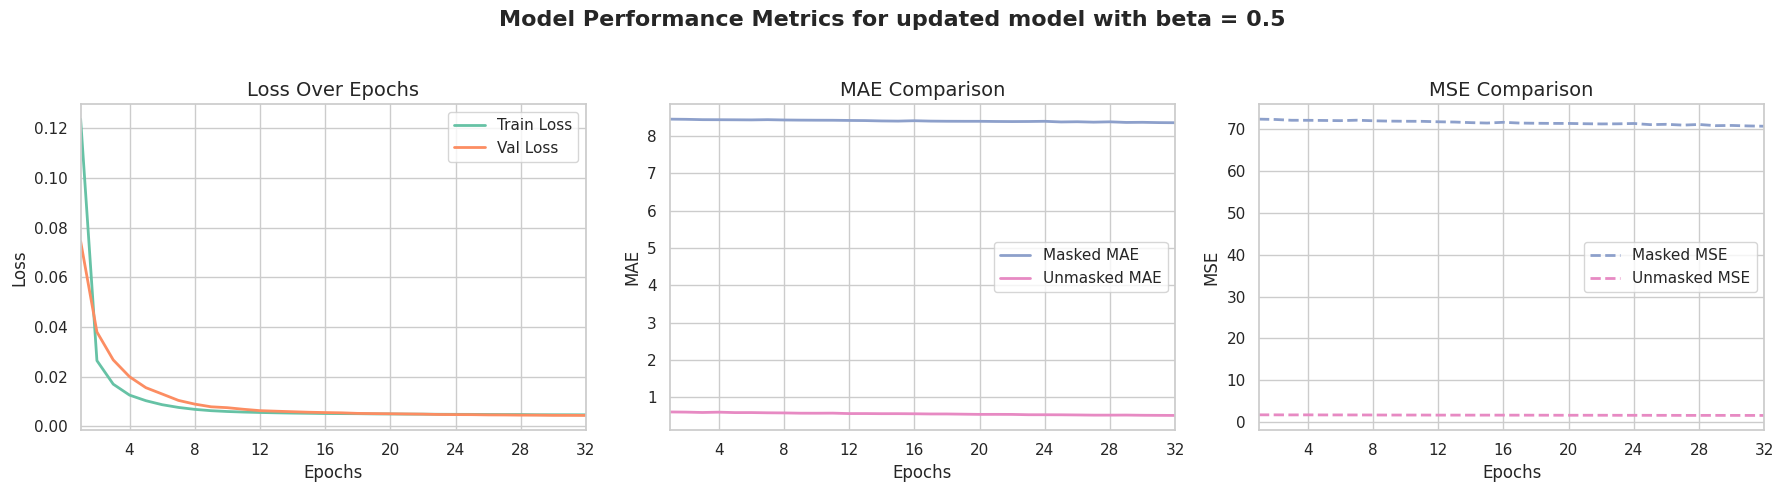

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def convert_tensor_list(lst):
    return [x.cpu().item() if torch.is_tensor(x) else x for x in lst]

train_loss_list = convert_tensor_list(train_loss_list)
val_loss_list = convert_tensor_list(val_loss_list)
mae_masked_list = convert_tensor_list(mae_masked_list)
mae_unmasked_list = convert_tensor_list(mae_unmasked_list)
mse_masked_list = convert_tensor_list(mse_masked_list)
mse_unmasked_list = convert_tensor_list(mse_unmasked_list)

# Apply a clean style
sns.set(style="whitegrid")

# Define the figure
plt.figure(figsize=(18, 5))
epochs_range = range(1, epochs+1)
x_ticks = np.arange(4, 33, 4)

# Define color palette
palette = sns.color_palette("Set2", 4)

# Plot Losses
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_list, label="Train Loss", color=palette[0], linewidth=2)
plt.plot(epochs_range, val_loss_list, label="Val Loss", color=palette[1], linewidth=2)
plt.title("Loss Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.xlim(1, 32)
plt.xticks(x_ticks)
plt.grid(True)

# Plot MAE (Masked and Unmasked)
plt.subplot(1, 3, 2)
plt.plot(epochs_range, mae_masked_list, label="Masked MAE", color=palette[2], linewidth=2)
plt.plot(epochs_range, mae_unmasked_list, label="Unmasked MAE", color=palette[3], linewidth=2)
plt.title("MAE Comparison", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.legend()
plt.xlim(1, 32)
plt.xticks(x_ticks)
plt.grid(True)

# Plot MSE (Masked and Unmasked)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, mse_masked_list, label="Masked MSE", color=palette[2], linestyle='--', linewidth=2)
plt.plot(epochs_range, mse_unmasked_list, label="Unmasked MSE", color=palette[3], linestyle='--', linewidth=2)
plt.title("MSE Comparison", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.legend()
plt.xlim(1, 32)
plt.xticks(x_ticks)
plt.grid(True)

plt.suptitle(f"Model Performance Metrics for updated model with beta = {beta}", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    "Train Loss": train_loss_list,
    "Validation Loss": val_loss_list,
    "MSE Masked": mse_masked_list,
    "MSE Unmasked": mse_unmasked_list,
    "MAE Masked": mae_masked_list,
    "MAE Unmasked": mae_unmasked_list,
})

# Save to CSV
df.to_csv("training_metrics.csv", index_label="Epoch")

In [ ]:
train_losses = {1000: [3473318.5, 3162800.511904762, 3047156.726190476, 3000443.3035714286, 2979012.869047619, 2967813.839285714, 2958978.613095238, 2955375.2976190476, 2950366.351190476, 2945682.136904762, 2938780.9226190476, 2935407.4196428573, 2932523.988095238, 2927449.6845238097, 2923535.0654761903, 2919587.1071428573, 2918400.3035714286, 2916327.285714286, 2910940.648809524, 2909614.238095238, 2904350.470238095, 2900815.619047619, 2896487.226190476, 2894780.6071428573, 2893099.101190476, 2890551.5595238097, 2886702.761904762, 2887338.0654761903, 2883158.0833333335, 2881768.4166666665, 2879528.8333333335, 2876660.2023809524], 0.5: [2716836.125, 2687930.494047619, 2681104.4464285714, 2678767.0416666665, 2676520.886904762, 2674786.279761905, 2673031.744047619, 2669923.529761905, 2667292.25, 2664274.0654761903, 2662391.738095238, 2659984.9523809524, 2654788.994047619, 2651367.8571428573, 2646678.776785714, 2644926.0773809524, 2643775.9523809524, 2638279.476190476, 2632498.1845238097, 2626217.714285714, 2622632.4345238097, 2618070.375, 2614139.7976190476, 2611344.339285714, 2606295.1458333335, 2602625.6904761903, 2599138.6845238097, 2595093.0416666665, 2589243.5654761903, 2586349.5416666665, 2583656.386904762, 2577833.6904761903]}
val_losses = {1000: [2346852.75, 2259459.0, 2232960.0, 2236051.5, 2244922.0, 2248819.5, 2247568.0, 2244339.25, 2241281.25, 2239437.5, 2237664.75, 2239227.5, 2241012.0, 2242161.0, 2244280.25, 2240325.25, 2239460.75, 2235503.75, 2232243.75, 2233387.0, 2229712.5, 2232446.0, 2227167.0, 2225982.5, 2225548.0, 2226335.5, 2227369.0, 2218172.5, 2221898.25, 2222077.0, 2222364.5, 2218507.0], 0.5: [2157213.75, 2146545.25, 2146795.0, 2144907.5, 2148283.5, 2143667.25, 2146097.0, 2145637.5, 2143749.0, 2143413.5, 2144465.5, 2144597.0, 2143314.0, 2146041.5, 2146216.5, 2145527.0, 2150124.5, 2142918.5, 2143032.75, 2148565.0, 2144665.5, 2143887.5, 2145304.25, 2143587.75, 2143905.5, 2146915.25, 2146329.0, 2142997.25, 2143597.5, 2147875.25, 2148567.25, 2149511.5]}

In [ ]:
# run this after every new run
train_losses[beta] = train_loss_list
val_losses[beta] = val_loss_list
print(f"{train_losses=}")
print(f"{val_losses=}")

train_losses={1000: [3473318.5, 3162800.511904762, 3047156.726190476, 3000443.3035714286, 2979012.869047619, 2967813.839285714, 2958978.613095238, 2955375.2976190476, 2950366.351190476, 2945682.136904762, 2938780.9226190476, 2935407.4196428573, 2932523.988095238, 2927449.6845238097, 2923535.0654761903, 2919587.1071428573, 2918400.3035714286, 2916327.285714286, 2910940.648809524, 2909614.238095238, 2904350.470238095, 2900815.619047619, 2896487.226190476, 2894780.6071428573, 2893099.101190476, 2890551.5595238097, 2886702.761904762, 2887338.0654761903, 2883158.0833333335, 2881768.4166666665, 2879528.8333333335, 2876660.2023809524], 0.5: [2716836.125, 2687930.494047619, 2681104.4464285714, 2678767.0416666665, 2676520.886904762, 2674786.279761905, 2673031.744047619, 2669923.529761905, 2667292.25, 2664274.0654761903, 2662391.738095238, 2659984.9523809524, 2654788.994047619, 2651367.8571428573, 2646678.776785714, 2644926.0773809524, 2643775.9523809524, 2638279.476190476, 2632498.1845238097, 2

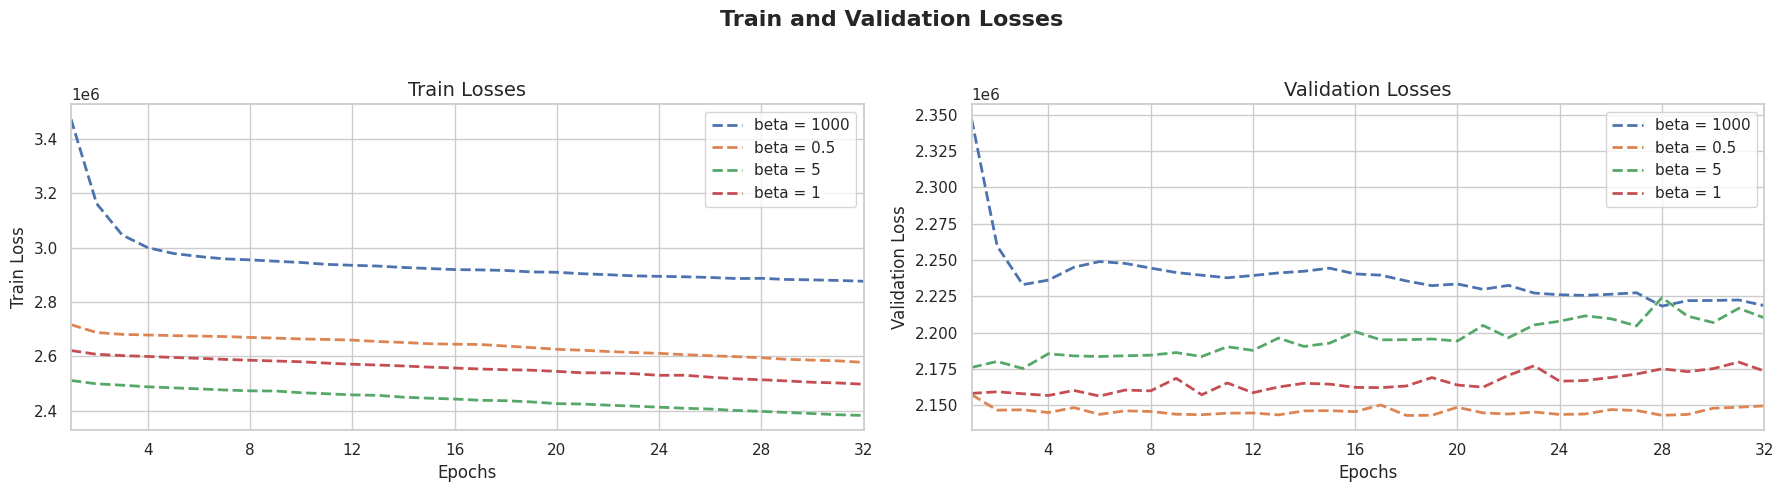

In [ ]:
# prompt: matplotlib code to plot x vs y

# Apply a clean style
sns.set(style="whitegrid")

# Define the figure
plt.figure(figsize=(18, 5))
epochs_range = range(1, 33)
x_ticks = np.arange(4, 33, 4)

# Define color palette
palette = sns.color_palette("Set2", 4)

# Plot Train Losses
plt.subplot(1, 2, 1)
for key, value in train_losses.items():
    plt.plot(epochs_range, value, label=f"beta = {key}", linestyle='--', linewidth=2)
plt.title("Train Losses", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Train Loss", fontsize=12)
plt.legend()
plt.xlim(1, 32)
plt.xticks(x_ticks)
plt.grid(True)

# Plot Validation Losses
plt.subplot(1, 2, 2)
for key, value in val_losses.items():
    plt.plot(epochs_range, value, label=f"beta = {key}", linestyle='--', linewidth=2)
plt.title("Validation Losses", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.legend()
plt.xlim(1, 32)
plt.xticks(x_ticks)
plt.grid(True)

plt.suptitle(f"Train and Validation Losses", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()